<a href="https://colab.research.google.com/github/i-salehi/CytEx/blob/main/CytEx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Upload
import io
import os
from google.colab import files
import csv
import openpyxl

# Print header message with larger font and red color
print("\033[1m\033[31m\033[6mCytEx\033[0m")
print("\n")

# Prompt user to upload file without bold formatting
print("\033[0mPlease upload the raw Excel file from Hamilton.")
print("\n")

# Create a file upload widget
upload_widget = files.upload()

# Read the uploaded file
for filename in upload_widget.keys():
    uploaded_file = upload_widget[filename]
    # Load the file into a bytes buffer
    file_buffer = io.BytesIO(uploaded_file)
    # Load the workbook from the bytes buffer
    workbook = openpyxl.load_workbook(file_buffer)
    # Print success message in green
    print(f"")
    print(f"The file {filename} was successfully saved.")

worksheet = workbook.active

# Set up variables to keep track of plates and misses
plates = 0
misses = 0

# Define a list to store the data for each plate, starting with column headers
plate_data_replicate_one = [["Row", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "Plate"]]
plate_data_replicate_two = [["Row", "1", "2", "3", "4", "5", "6", "7", "8", "9", "10", "11", "12", "Plate"]]

# Loop through each cell in the worksheet
for i, row in enumerate(worksheet.iter_rows()):
    for cell in row:
        # Check if the cell contains a 1 and the cell to the left is empty
        if cell.value == 1 and cell.offset(row=0, column=-1).value is None:
            # Check if the cell below the empty cell contains an A
            if cell.offset(row=1, column=-1).value == 'A':
                plates += 1
                # Get the coordinates of the three cells involved in the plate selection
                top_left = (cell.column, cell.row)
                bottom_left = (cell.offset(row=1, column=-1).column, cell.offset(row=1, column=-1).row)
                top_right = (cell.offset(row=0, column=-1).column, cell.offset(row=0, column=-1).row)
                # Define the coordinates of the bottom right corner of the rectangle
                bottom_right = (top_right[0] + 12, bottom_left[1] + 8)
                # Store the cell values in a list with the plate number
                for r in range(cell.row + 1, cell.row + 9):  # Exclude the first row
                    row_data = [worksheet.cell(row=r, column=c).value for c in range(cell.column - 1, cell.column + 12)]
                    if plates <= 10:
                        row_data.append(plates)
                        plate_data_replicate_one.append(row_data)
                    else:
                        row_data.append(plates-10)
                        plate_data_replicate_two.append(row_data)
            else:
                misses += 1
        else:
            misses += 1

# Output the number of plates and misses
print(f"")
print(f"Number of plates: {plates}")
print(f"\033[32mExtracted data saved as Replicate_One.csv, and Replicate_Two.csv\033[32m")

# Write the plate data to a CSV file for replicate one
with open('/content/Replicate_One.csv', mode='w') as output_file:
    output_writer = csv.writer(output_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for plate_cells in plate_data_replicate_one:
        output_writer.writerow(plate_cells)

# Write the plate data to a CSV file for replicate two
with open('/content/Replicate_Two.csv', mode='w') as output_file:
    output_writer = csv.writer(output_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    for plate_cells in plate_data_replicate_two:
        output_writer.writerow(plate_cells)

  

In [2]:
#@title MIC Caller - Replicate One

import pandas as pd

# Read in the CSV file
df = pd.read_csv("/content/Replicate_One.csv", header=0, sep=",")

# Drop the "Plate" column
df = df.drop(columns=["Plate"])

# Rename columns
df.columns = ["Row"] + [str(i) for i in range(1,13)]

# Reset the index
df = df.reset_index(drop=True)

# Create a factor variable for the plate number
df["plate"] = pd.cut(df.index, bins=10, labels=False)

# Split the data into 10 plates
plates = [group[1] for group in df.groupby("plate")]

# Rename the row names for each plate
for i in range(10):
    plates[i].index = ["A", "B", "C", "D", "E", "F", "G", "H"]

# Define a dictionary to map plate numbers to values
plate_map = {
    "Plate 10": 0.25,
    "Plate 9": 0.5,
    "Plate 8": 1,
    "Plate 7": 2,
    "Plate 6": 4,
    "Plate 5": 8,
    "Plate 4": 16,
    "Plate 3": 32,
    "Plate 2": 64,
    "Plate 1": 128,
}

# Create a dictionary to store the well values
well_data = {}
for col in range(1, 13):
    for row in "ABCDEFGH":
        well_name = row + str(col)
        for i in range(10):
            plate_name = "Plate " + str(i+1)
            value = plates[i].at[row, str(col)]
            if well_name not in well_data:
                well_data[well_name] = {}
            # Update plate name to match the plate names in plate_map dictionary
            plate_name_map = plate_map.get(plate_name, None)
            if plate_name_map is not None:
                well_data[well_name][plate_name_map] = value

# Create a DataFrame from the well data dictionary
well_df = pd.DataFrame.from_dict(well_data, orient="index")

# Rename the columns using the plate_map dictionary
well_df = well_df.rename(columns=plate_map)

# Define a function to determine MIC for each row
def get_mic(row):
    if row.name in ['H1', 'H2', 'H3', 'H4', 'H5', 'H6']:
        return "Sterility Control"
    elif row.name in ['H7', 'H8', 'H9', 'H10', 'H11', 'H12']:
        return "Growth Control"
    else:
        for plate_name in plate_map.values():
            col_name = plate_name
            value = row[col_name]
            if pd.notna(value) and value < 0.499:
                return plate_name
    return ">128"

# Define the desired row order using nested list comprehension
row_order = [f"{row}{col}" for row in "ABCDEFGH" for col in range(1, 13)]

# Select the rows in the desired order
well_df = well_df.loc[row_order]

# Apply the function to each row of the dataframe
well_df["MIC"] = well_df.apply(get_mic, axis=1)

# Save the data as an Excel file
well_df.to_excel("Replicate_One_MIC.xlsx")


In [3]:
#@title MIC Caller - Replicate Two

import pandas as pd

# Read in the CSV file
df = pd.read_csv("/content/Replicate_Two.csv", header=0, sep=",")

# Drop the "Plate" column
df = df.drop(columns=["Plate"])

# Rename columns
df.columns = ["Row"] + [str(i) for i in range(1,13)]

# Reset the index
df = df.reset_index(drop=True)

# Create a factor variable for the plate number
df["plate"] = pd.cut(df.index, bins=10, labels=False)

# Split the data into 10 plates
plates = [group[1] for group in df.groupby("plate")]

# Rename the row names for each plate
for i in range(10):
    plates[i].index = ["A", "B", "C", "D", "E", "F", "G", "H"]

# Define a dictionary to map plate numbers to values
plate_map = {
    "Plate 10": 0.25,
    "Plate 9": 0.5,
    "Plate 8": 1,
    "Plate 7": 2,
    "Plate 6": 4,
    "Plate 5": 8,
    "Plate 4": 16,
    "Plate 3": 32,
    "Plate 2": 64,
    "Plate 1": 128,
}

# Create a dictionary to store the well values
well_data = {}
for col in range(1, 13):
    for row in "ABCDEFGH":
        well_name = row + str(col)
        for i in range(10):
            plate_name = "Plate " + str(i+1)
            value = plates[i].at[row, str(col)]
            if well_name not in well_data:
                well_data[well_name] = {}
            # Update plate name to match the plate names in plate_map dictionary
            plate_name_map = plate_map.get(plate_name, None)
            if plate_name_map is not None:
                well_data[well_name][plate_name_map] = value

# Create a DataFrame from the well data dictionary
well_df = pd.DataFrame.from_dict(well_data, orient="index")

# Rename the columns using the plate_map dictionary
well_df = well_df.rename(columns=plate_map)

# Define a function to determine MIC for each row
def get_mic(row):
    if row.name in ['H1', 'H2', 'H3', 'H4', 'H5', 'H6']:
        return "Sterility Control"
    elif row.name in ['H7', 'H8', 'H9', 'H10', 'H11', 'H12']:
        return "Growth Control"
    else:
        for plate_name in plate_map.values():
            col_name = plate_name
            value = row[col_name]
            if pd.notna(value) and value < 0.499:
                return plate_name
    return ">128"

# Define the desired row order using nested list comprehension
row_order = [f"{row}{col}" for row in "ABCDEFGH" for col in range(1, 13)]

# Select the rows in the desired order
well_df = well_df.loc[row_order]

# Apply the function to each row of the dataframe
well_df["MIC"] = well_df.apply(get_mic, axis=1)

# Save the data as an Excel file
well_df.to_excel("Replicate_Two_MIC.xlsx")


In [4]:
#@title MIC Caller - Combined
import pandas as pd
import openpyxl
from openpyxl.styles import Color, Fill, PatternFill, GradientFill, Alignment
from openpyxl.formatting.rule import ColorScaleRule

# Load the replicate one data
replicate_one = pd.read_excel("/content/Replicate_One_MIC.xlsx")
replicate_two = pd.read_excel("/content/Replicate_Two_MIC.xlsx")

# Replace None values in headers with empty string
replicate_one_headers = ["" if header is None else header for header in list(replicate_one.columns)]
replicate_two_headers = ["" if header is None else header for header in list(replicate_two.columns)]
replicate_two_headers = [''] + replicate_two_headers

# Create a new workbook
workbook = openpyxl.Workbook()

# Get the active worksheet
worksheet = workbook.active

# Define the starting row and column for each replicate
replicate_one_row = 2
replicate_one_col = 1
replicate_two_row = 2
replicate_two_col = 14

# Add the column headers to the worksheet
worksheet.append(replicate_one_headers + replicate_two_headers)

# Add the replicate one data to the worksheet
for r in range(replicate_one.shape[0]):
    for c in range(replicate_one.shape[1]):
        cell = worksheet.cell(row=replicate_one_row+r, column=replicate_one_col+c, value=replicate_one.iloc[r,c])
        cell.alignment = Alignment(horizontal='center', vertical='center')

# Add the replicate two data to the worksheet
for r in range(replicate_two.shape[0]):
    for c in range(replicate_two.shape[1]):
        cell = worksheet.cell(row=replicate_two_row+r, column=replicate_two_col+c, value=replicate_two.iloc[r,c])
        cell.alignment = Alignment(horizontal='center', vertical='center')

# Rename column named "Unnamed: 0"
for cell in worksheet[1]:
    if cell.value == "Unnamed: 0":
        cell.value = ""

# Center column headers
for row in worksheet[1:2]:
    for cell in row:
        cell.alignment = Alignment(horizontal='center', vertical='center')

# Set width of columns L and Y
worksheet.column_dimensions['L'].width = 16
worksheet.column_dimensions['Y'].width = 16

# Add color scales to rectangles
first_rectangle_range = "B2:K97"
second_rectangle_range = "O2:X97"

# Create color scale rules for the two rectangles
red_scale_rule = ColorScaleRule(start_type="min", start_color="FFFFFF", end_type="max", end_color="FF5733")
blue_scale_rule = ColorScaleRule(start_type="min", start_color="FFFFFF", end_type="max", end_color="3399FF")

# Apply color scale rules to the two rectangles
for row in worksheet[first_rectangle_range]:
    for cell in row:
        cell.fill = GradientFill(stop=[Color("FFFFFF"), Color("FF5733")])
worksheet.conditional_formatting.add(first_rectangle_range, red_scale_rule)

for row in worksheet[second_rectangle_range]:
    for cell in row:
        cell.fill = GradientFill(stop=[Color("FFFFFF"), Color("3399FF")])
worksheet.conditional_formatting.add(second_rectangle_range, blue_scale_rule)

# Save the workbook
workbook.save("combinedMIC.xlsx")


Future Ideas

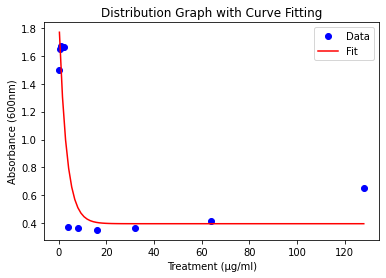

a = 1.4850446526250167
b = 0.3202546228956455
c = 0.3974228419816429


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

# Define the function to fit
def func(x, a, b, c):
    return a * np.exp(-b * x) + c

# Define the data
Absorbance = [0.653, 0.417, 0.365, 0.353, 0.369, 0.374, 1.66, 1.669, 1.647, 1.5]
treatments = [128, 64, 32, 16, 8, 4, 2, 1, 0.5, 0.25] # convert µg/ml to numerical values

# Perform curve fitting
popt, pcov = curve_fit(func, treatments, values)

# Generate data for the fitted curve
x_fit = np.linspace(0.25, 128, 100)
y_fit = func(x_fit, *popt)

# Plot the data and fitted curve
plt.plot(treatments, values, 'bo', label='Data')
plt.plot(x_fit, y_fit, 'r-', label='Fit')
plt.xlabel('Treatment (µg/ml)')
plt.ylabel('Absorbance (600nm)')
plt.title('Distribution Graph with Curve Fitting')
plt.legend()
plt.show()

# Print the fitting parameters
print('a =', popt[0])
print('b =', popt[1])
print('c =', popt[2])


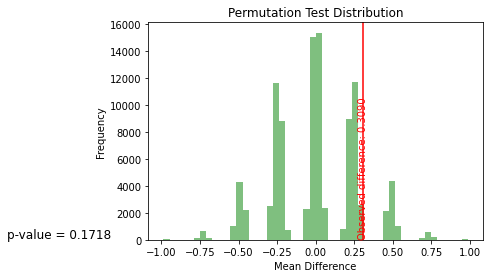

In [ ]:
import numpy as np
import itertools
import matplotlib.pyplot as plt

# Define the two groups
group1 = np.array([0.405, 0.41, 0.408, 0.384, 0.417, 1.612, 1.712, 1.722, 1.677, 1.6521])
group2 = np.array([0.437, 0.421, 0.37, 0.378, 0.391, 0.377, 0.376, 1.531, 1.542, 1.486])

# Define the number of permutations
n_permutations = 100000

# Calculate the observed difference between the means of the two groups
observed_diff = np.mean(group1) - np.mean(group2)

# Concatenate the data from the two groups
data = np.concatenate((group1, group2))

# Initialize an array to store the permutation differences
permutation_diffs = np.zeros(n_permutations)

# Generate the permutation distribution by shuffling the data and computing the differences
for i in range(n_permutations):
    np.random.shuffle(data)
    permutation_diffs[i] = np.mean(data[:len(group1)]) - np.mean(data[len(group1):])

# Calculate the p-value as the proportion of permutation differences that are more extreme than the observed difference
p_value = (np.sum(permutation_diffs >= observed_diff) + np.sum(permutation_diffs <= -observed_diff)) / n_permutations

# Plot the permutation distribution
plt.hist(permutation_diffs, bins=50, alpha=0.5, color='green')
# Add a vertical line for the observed difference
plt.axvline(x=observed_diff, color='red')
# Add a label for the observed difference
plt.text(observed_diff, 50, f'Observed difference: {observed_diff:.4f}', rotation=90, va='bottom', ha='center', color='red')
# Add a title and axis labels
plt.title('Permutation Test Distribution')
plt.xlabel('Mean Difference')
plt.ylabel('Frequency')
# Add a caption for the p-value
plt.text(-2, 120, f'p-value = {p_value:.4f}', fontsize=12)
# Show the plot
plt.show()
